
**Task 2 of Mini Project: Text Classification using Deep Learning**

**1. Data Loading**

In [ ]:
# Install required libraries (run once)
!pip install nltk keras gensim scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
!pip uninstall -y numpy pandas
!pip install numpy==1.25.0 pandas==2.0.3

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Input       1013 non-null   object
 1   Prediction  1013 non-null   object
dtypes: object(2)
memory usage: 16.0+ KB
None

Sample data:
                                               Input Prediction
0  Tesla's stock experienced a remarkable 5% surg...   Positive
1  Concerns over a looming market crash have inte...   Negative
2  The S&P 500 index closed the day without any s...    Neutral
3  Apple reported that its latest iPhone model ac...   Positive
4  Despite Microsoft delivering a robust quarterl...   Negative
Unique labels in Prediction: ['Positive' 'Negative' 'Neutral']


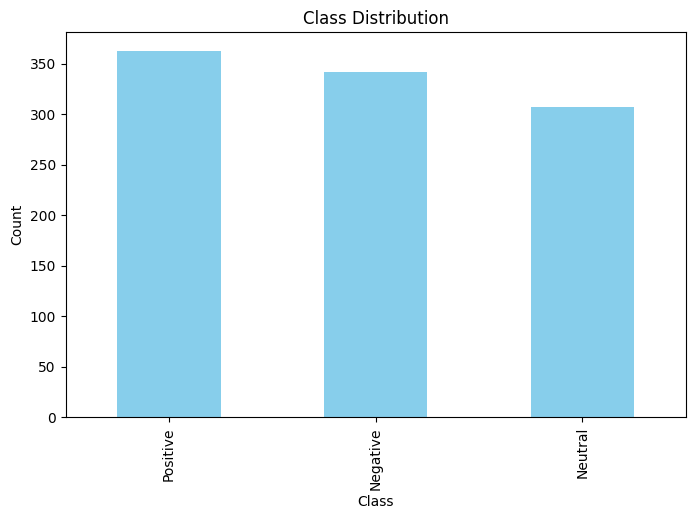

Training set size: 728
Validation set size: 81
Test set size: 203


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the dataset from 'data.csv'
data = pd.read_csv('data.csv')

if data.iloc[0].isnull().all():
    data = data.drop(index=0).reset_index(drop=True)

# Overview of the dataset
print("Dataset overview:")
print(data.info())
print("\nSample data:")
print(data.head())

# Clean the 'Prediction' column: remove extra whitespace
data['Prediction'] = data['Prediction'].astype(str).str.strip()
data = data[data['Prediction'].str.lower() != 'neutra']
# Print unique labels in the 'Prediction' column
print("Unique labels in Prediction:", data['Prediction'].unique())

# Plot class distribution
plt.figure(figsize=(8, 5))
data['Prediction'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Split the dataset into training, validation, and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))


**2. Text Processing**

In [ ]:
import re
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Define a function to clean and preprocess text
def preprocess_text(text):
    if not isinstance(text, str):
        return ""  # Return empty string for non-string entries
    text = text.lower()                                  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)                       # Remove special characters
    text = re.sub(r'\s+', ' ', text)                      # Remove extra spaces
    tokens = word_tokenize(text)                         # Tokenize text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(tokens)

# Apply preprocessing to the training, validation, and testing sets using the "Input" column
train_data['processed_text'] = train_data['Input'].apply(preprocess_text)
val_data['processed_text']   = val_data['Input'].apply(preprocess_text)
test_data['processed_text']  = test_data['Input'].apply(preprocess_text)

print(train_data[['Input', 'processed_text']].head())


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                                 Input  \
48   Investor activity has slowed significantly tod...   
715  A weak global economic outlook has sparked con...   
497  Infosys shares remained flat, reflecting a lac...   
9    Google's recent advancements in artificial int...   
401  HDFC Bank saw steady gains throughout the day,...   

                                        processed_text  
48   investor activity slowed significantly today m...  
715  weak global economic outlook sparked concerns ...  
497  infosys shares remained flat reflecting lack i...  
9    google recent advancements artificial intellig...  
401  hdfc bank saw steady gains throughout day inve...  


**3. Text Embedding**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
import numpy as np

# --- Bag of Words (BoW) ---
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_bow   = bow_vectorizer.transform(val_data['processed_text']).toarray()
X_test_bow  = bow_vectorizer.transform(test_data['processed_text']).toarray()

# --- TF-IDF ---
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()
X_val_tfidf   = tfidf_vectorizer.transform(val_data['processed_text']).toarray()
X_test_tfidf  = tfidf_vectorizer.transform(test_data['processed_text']).toarray()

# --- FastText Embeddings ---
# Train a FastText model on tokenized text (split each processed text into words)
fasttext_model = gensim.models.FastText(
    sentences=train_data['processed_text'].apply(lambda x: x.split()),
    vector_size=100, window=5, min_count=5
)

# Function to compute an average FastText embedding for a given text
def get_fasttext_embedding(text, model):
    words = text.split()
    if len(words) == 0:
        return np.zeros(model.vector_size)
    valid_words = [word for word in words if word in model.wv]
    if not valid_words:
        return np.zeros(model.vector_size)
    return np.mean([model.wv[word] for word in valid_words], axis=0)

X_train_fasttext = np.vstack(train_data['processed_text'].apply(lambda x: get_fasttext_embedding(x, fasttext_model)))
X_val_fasttext   = np.vstack(val_data['processed_text'].apply(lambda x: get_fasttext_embedding(x, fasttext_model)))
X_test_fasttext  = np.vstack(test_data['processed_text'].apply(lambda x: get_fasttext_embedding(x, fasttext_model)))

print("Embedding completed for BoW, TF-IDF, and FastText.")


Embedding completed for BoW, TF-IDF, and FastText.



**4. Model Training with Different Architectures**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_seq_length = 100  # Adjust based on your data

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['processed_text'])
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_data['processed_text']), maxlen=max_seq_length)
X_val_seq   = pad_sequences(tokenizer.texts_to_sequences(val_data['processed_text']), maxlen=max_seq_length)
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(test_data['processed_text']), maxlen=max_seq_length)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize the LabelEncoder
le = LabelEncoder()
# This creates a numeric mapping for the classes (e.g., {'Negative': 0, 'Neutral': 1, 'Positive': 2})
y_train_numeric = le.fit_transform(train_data['Prediction'])
# Transform the validation and test labels using the same encoder
y_val_numeric   = le.transform(val_data['Prediction'])
y_test_numeric  = le.transform(test_data['Prediction'])

# One-hot encode the numeric labels for training the deep learning model.
# This converts each label into a vector of length equal to the number of classes.
y_train_enc = to_categorical(y_train_numeric)
y_val_enc   = to_categorical(y_val_numeric)
y_test_enc  = to_categorical(y_test_numeric)

# Print the label mapping for reference.
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


Label mapping: {'Negative': 0, 'Neutral': 1, 'Positive': 2}


**5. Comparative Analysis of Models**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Bidirectional

# Set parameters
input_dim = max_words  # Vocabulary size (e.g., 5000)
num_classes = y_train_enc.shape[1]  # Number of classes (e.g., 3 for Negative, Neutral, Positive)

# --------- Model 1: CNN Model ---------
def cnn_model(input_dim, num_classes, max_seq_length):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=128, input_length=max_seq_length))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn = cnn_model(input_dim, num_classes, max_seq_length)
print("CNN Model Summary:")
cnn.summary()
cnn_history = cnn.fit(X_train_seq, y_train_enc,
                      validation_data=(X_val_seq, y_val_enc),
                      epochs=5, batch_size=64)

# --------- Model 2: LSTM Model ---------
def lstm_model(input_dim, num_classes, max_seq_length):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=128, input_length=max_seq_length))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm = lstm_model(input_dim, num_classes, max_seq_length)
print("LSTM Model Summary:")
lstm.summary()
lstm_history = lstm.fit(X_train_seq, y_train_enc,
                        validation_data=(X_val_seq, y_val_enc),
                        epochs=5, batch_size=64)

# --------- Model 3: BiLSTM Model (Pure Bidirectional LSTM) ---------
def bilstm_model(input_dim, num_classes, max_seq_length):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=128, input_length=max_seq_length))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

bilstm = bilstm_model(input_dim, num_classes, max_seq_length)
print("BiLSTM Model Summary:")
bilstm.summary()
bilstm_history = bilstm.fit(X_train_seq, y_train_enc,
                            validation_data=(X_val_seq, y_val_enc),
                            epochs=5, batch_size=64)

# --------- Model 4: CNN-BiLSTM Model (Hybrid) ---------
def cnn_bilstm_model(input_dim, num_classes, max_seq_length):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=128, input_length=max_seq_length))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_bilstm = cnn_bilstm_model(input_dim, num_classes, max_seq_length)
print("CNN-BiLSTM Model Summary:")
cnn_bilstm.summary()
cnn_bilstm_history = cnn_bilstm.fit(X_train_seq, y_train_enc,
                                    validation_data=(X_val_seq, y_val_enc),
                                    epochs=5, batch_size=64)


CNN Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.3535 - loss: 1.1012 - val_accuracy: 0.3086 - val_loss: 1.0932
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5089 - loss: 1.0532 - val_accuracy: 0.5185 - val_loss: 1.0276
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7447 - loss: 0.9109 - val_accuracy: 0.8148 - val_loss: 0.7248
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9010 - loss: 0.5015 - val_accuracy: 0.8395 - val_loss: 0.4417
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9689 - loss: 0.1611 - val_accuracy: 0.9012 - val_loss: 0.3569
LSTM Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.3823 - loss: 1.0873 - val_accuracy: 0.3333 - val_loss: 1.0513
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.6160 - loss: 0.9424 - val_accuracy: 0.7284 - val_loss: 0.7746
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step - accuracy: 0.8790 - loss: 0.5558 - val_accuracy: 0.8395 - val_loss: 0.5691
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.9252 - loss: 0.3196 - val_accuracy: 0.8889 - val_loss: 0.4478
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.9697 - loss: 0.1339 - val_accuracy: 0.9012 - val_loss: 0.4344
BiLSTM Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 532ms/step - accuracy: 0.3673 - loss: 1.0906 - val_accuracy: 0.3086 - val_loss: 1.0650
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 442ms/step - accuracy: 0.6020 - loss: 0.9878 - val_accuracy: 0.8025 - val_loss: 0.8167
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 436ms/step - accuracy: 0.8489 - loss: 0.6349 - val_accuracy: 0.8519 - val_loss: 0.4767
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 427ms/step - accuracy: 0.9232 - loss: 0.2976 - val_accuracy: 0.8519 - val_loss: 0.4090
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 492ms/step - accuracy: 0.9493 - loss: 0.1765 - val_accuracy: 0.8765 - val_loss: 0.3887
CNN-BiLSTM Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 436ms/step - accuracy: 0.3604 - loss: 1.0929 - val_accuracy: 0.3086 - val_loss: 1.0799
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.4954 - loss: 1.0046 - val_accuracy: 0.6667 - val_loss: 0.7859
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.7799 - loss: 0.6981 - val_accuracy: 0.8519 - val_loss: 0.5798
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - accuracy: 0.9421 - loss: 0.2925 - val_accuracy: 0.8889 - val_loss: 0.4315
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.9687 - loss: 0.0895 - val_accuracy: 0.8889 - val_loss: 0.4025


In [ ]:
import time
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Convert one-hot encoded test labels to class indices
y_test_classes = y_test_enc.argmax(axis=1)

# Dictionary to store results
results = {}

# Evaluate each model and measure inference time

# ----- CNN -----
start_time = time.time()
y_pred_cnn = cnn.predict(X_test_seq)
cnn_inference_time = time.time() - start_time
y_pred_classes_cnn = y_pred_cnn.argmax(axis=1)

cnn_acc = accuracy_score(y_test_classes, y_pred_classes_cnn)
cnn_report = classification_report(y_test_classes, y_pred_classes_cnn, output_dict=True)

results["CNN"] = [cnn_acc, cnn_report["weighted avg"]["precision"], cnn_report["weighted avg"]["recall"], cnn_report["weighted avg"]["f1-score"], cnn_inference_time]

# ----- LSTM -----
start_time = time.time()
y_pred_lstm = lstm.predict(X_test_seq)
lstm_inference_time = time.time() - start_time
y_pred_classes_lstm = y_pred_lstm.argmax(axis=1)

lstm_acc = accuracy_score(y_test_classes, y_pred_classes_lstm)
lstm_report = classification_report(y_test_classes, y_pred_classes_lstm, output_dict=True)

results["LSTM"] = [lstm_acc, lstm_report["weighted avg"]["precision"], lstm_report["weighted avg"]["recall"], lstm_report["weighted avg"]["f1-score"], lstm_inference_time]

# ----- BiLSTM -----
start_time = time.time()
y_pred_bilstm = bilstm.predict(X_test_seq)
bilstm_inference_time = time.time() - start_time
y_pred_classes_bilstm = y_pred_bilstm.argmax(axis=1)

bilstm_acc = accuracy_score(y_test_classes, y_pred_classes_bilstm)
bilstm_report = classification_report(y_test_classes, y_pred_classes_bilstm, output_dict=True)

results["BiLSTM"] = [bilstm_acc, bilstm_report["weighted avg"]["precision"], bilstm_report["weighted avg"]["recall"], bilstm_report["weighted avg"]["f1-score"], bilstm_inference_time]

# ----- CNN-BiLSTM -----
start_time = time.time()
y_pred_cnn_bilstm = cnn_bilstm.predict(X_test_seq)
cnn_bilstm_inference_time = time.time() - start_time
y_pred_classes_cnn_bilstm = y_pred_cnn_bilstm.argmax(axis=1)

cnn_bilstm_acc = accuracy_score(y_test_classes, y_pred_classes_cnn_bilstm)
cnn_bilstm_report = classification_report(y_test_classes, y_pred_classes_cnn_bilstm, output_dict=True)

results["CNN-BiLSTM"] = [cnn_bilstm_acc, cnn_bilstm_report["weighted avg"]["precision"], cnn_bilstm_report["weighted avg"]["recall"], cnn_bilstm_report["weighted avg"]["f1-score"], cnn_bilstm_inference_time]

# Convert results to a DataFrame
df_results = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1-score", "Inference Time (s)"]).T
print("\nModel Performance Comparison:\n")
print(df_results)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step

Model Performance Comparison:

            Accuracy  Precision    Recall  F1-score  Inference Time (s)
CNN         0.931034   0.931270  0.931034  0.930921            0.299065
LSTM        0.911330   0.912347  0.911330  0.911404            1.100554
BiLSTM      0.935961   0.936842  0.935961  0.936013            2.599622
CNN-BiLSTM  0.931034   0.933324  0.931034  0.931270            2.597204


**6. Saving the Best Model**

In [ ]:
cnn_bilstm.save('cnn_bilstm_model.keras')

cnn.save('cnn_model.keras')  # CNN Model
lstm.save('lstm_model.keras')  # LSTM Model
bilstm.save('bilstm_model.keras')  # BiLSTM Model

print("All models saved successfully.")

import pickle

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("Tokenizer and label encoder saved.")


All models saved successfully.
Tokenizer and label encoder saved.


**7. Prediction on Real-World Input**

In [ ]:
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

# Define a text preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Load new test data (test.csv with 100 unknown inputs)
df_new = pd.read_csv('test.csv')
print("New test data preview:")
print(df_new.head())

# Preprocess the text
df_new['processed_text'] = df_new['Input'].apply(preprocess_text)

# Load the saved tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Convert new text to sequences and pad them
X_new_seq = pad_sequences(tokenizer.texts_to_sequences(df_new['processed_text']), maxlen=max_seq_length)

# Load all four models
cnn_model = load_model('cnn_model.keras')
lstm_model = load_model('lstm_model.keras')
bilstm_model = load_model('bilstm_model.keras')
cnn_bilstm_model = load_model('cnn_bilstm_model.keras')

# Predict using all models
pred_cnn = cnn_model.predict(X_new_seq).argmax(axis=1)
pred_lstm = lstm_model.predict(X_new_seq).argmax(axis=1)
pred_bilstm = bilstm_model.predict(X_new_seq).argmax(axis=1)
pred_cnn_bilstm = cnn_bilstm_model.predict(X_new_seq).argmax(axis=1)

# Load the saved label encoder
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Convert numeric predictions back to original class labels
df_new['CNN_Prediction'] = le.inverse_transform(pred_cnn)
df_new['LSTM_Prediction'] = le.inverse_transform(pred_lstm)
df_new['BiLSTM_Prediction'] = le.inverse_transform(pred_bilstm)
df_new['CNN_BiLSTM_Prediction'] = le.inverse_transform(pred_cnn_bilstm)

# Display predictions
pd.set_option('display.max_rows', None)
print("Predictions for new data:")
print(df_new[['Input', 'CNN_Prediction', 'LSTM_Prediction', 'BiLSTM_Prediction', 'CNN_BiLSTM_Prediction']].head(100).to_string())



New test data preview:
                                               Input Prediction
0  Global stock markets surge as investors respon...   Positive
1  The technology sector sees a record-breaking r...   Positive
2  Oil prices climb to their highest levels in th...   Positive
3  Banking stocks experience a strong upward mome...   Positive
4  The auto industry witnesses a significant rise...   Positive
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 13 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step
Predictions for new data:
                                                                                                                                                          Input CNN_Prediction LSTM_Prediction BiLSTM_Prediction CNN_BiLSTM_Prediction
0     Global stock markets surge as investors respond positively to the latest economic stimulus package, fueling optimism for a strong post-pandemic recovery.       Positive        Positive          Positive              Positive
1    The technology sector sees a record-breaking rally after several major firms report better-than-expected quarterly earnings, driving up market confidence.       Positive        Positive          Positive              Positive
2                      Oil prices climb to their highest levels in three years, boosting energy sector stocks and signaling st

Human vs model prediction for cnn_bilstm:

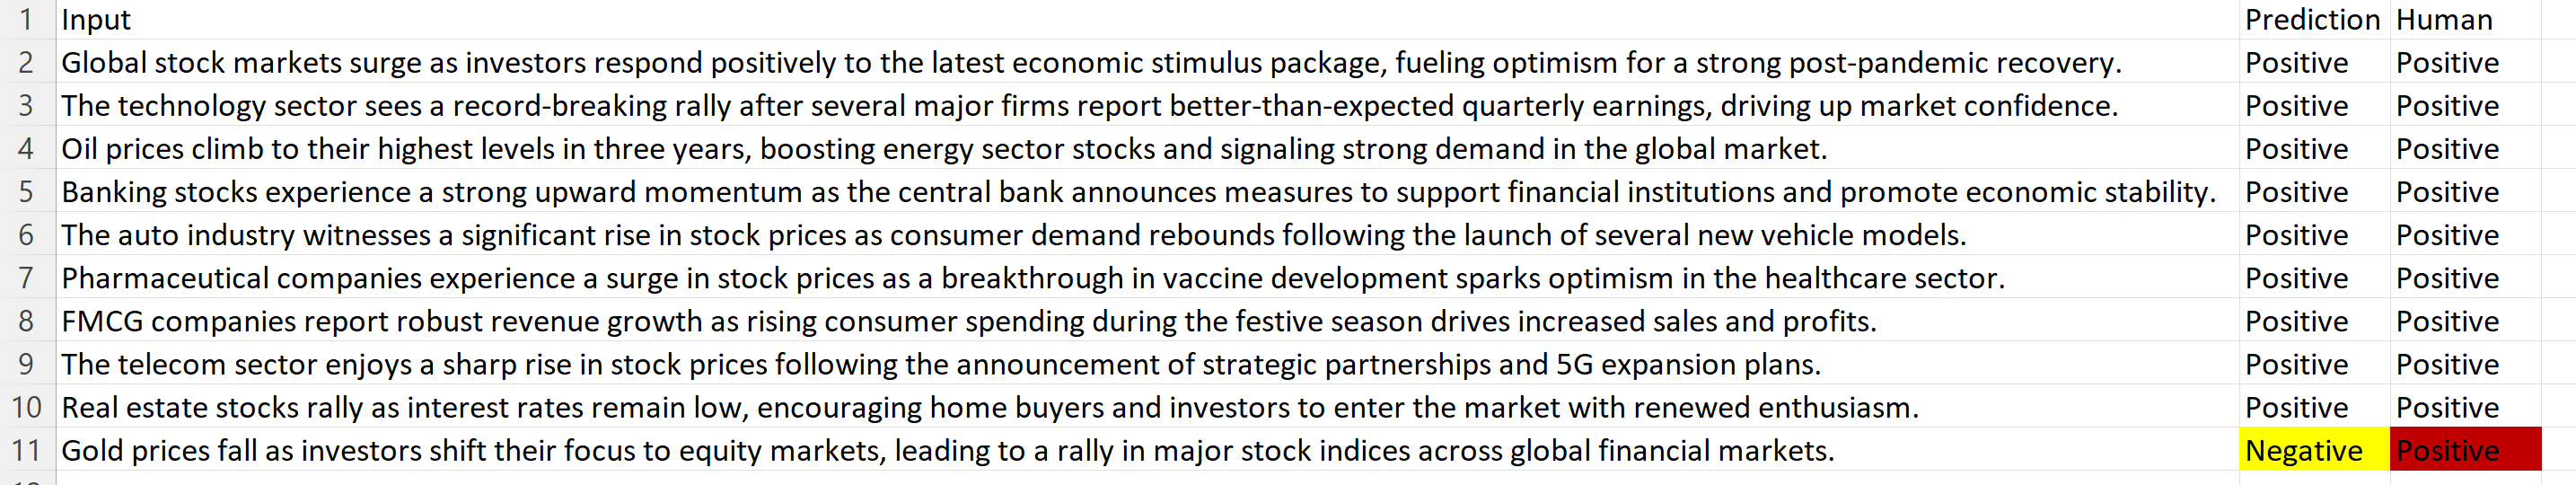

**Human vs model prediction for all models:**

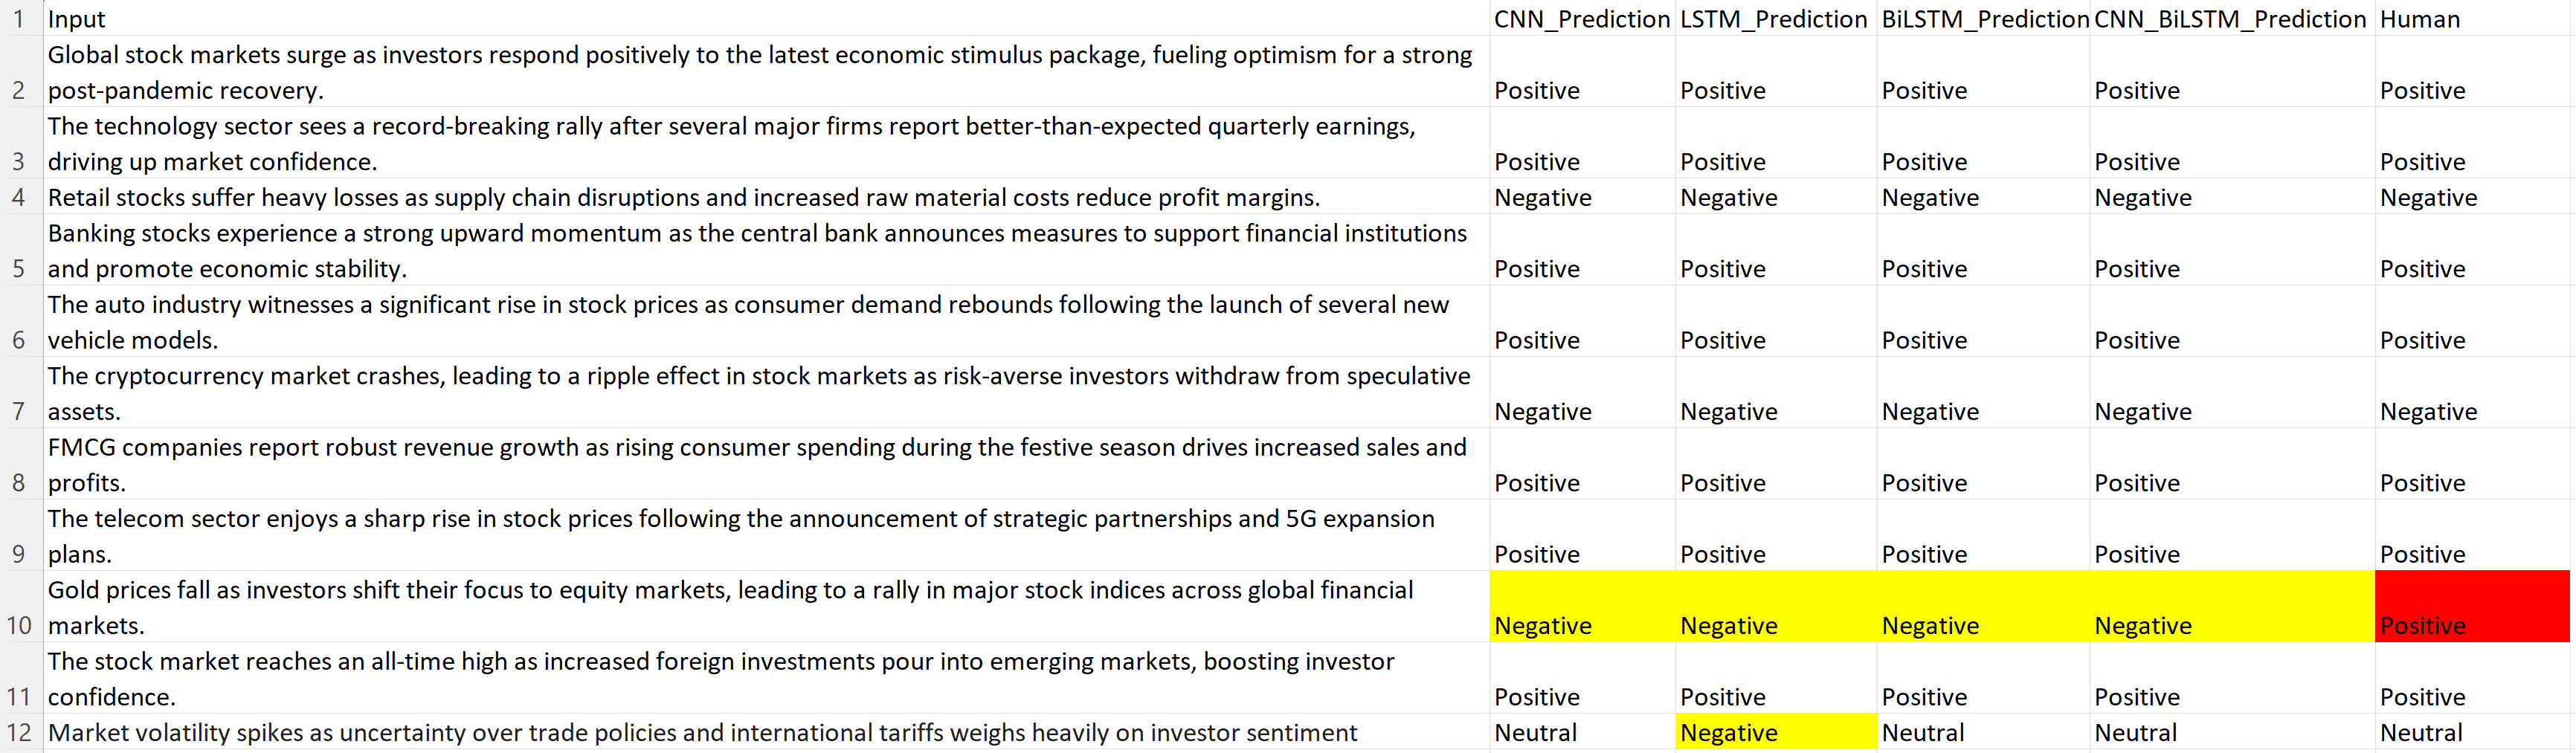